In [35]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import altair as alt

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

## Exercise 1: Dataset and preliminary EDA
<hr>
This is a classification dataset, and the task is to predict whether customers will stay or churn.

The starter code below loads the data from a CSV file, assuming it is saved as `model_data_raw.xlsx` under the `data` folder.

_Note that many popular datasets have sex as a feature where the possible values are male and female. This representation reflects how the data were collected and is not meant to imply that, for example, gender is binary._

In [36]:
file_path = "data/model_data_raw.xlsx"
churn_df = pd.read_excel(file_path, sheet_name='vw_churndata')
churn_df.shape

(6007, 32)

In [37]:
churn_df.head

<bound method NDFrame.head of      customer_id  gender  age married          state  number_of_referrals  \
0      19877-DEL    Male   35      No          Delhi                    7   
1      58353-MAH  Female   45     Yes    Maharashtra                   14   
2      25063-WES    Male   51      No    West Bengal                    4   
3      59787-KAR    Male   79      No      Karnataka                    3   
4      28544-TAM  Female   80      No     Tamil Nadu                    3   
...          ...     ...  ...     ...            ...                  ...   
6002   43397-UTT  Female   41      No  Uttar Pradesh                    6   
6003   22240-HAR    Male   51     Yes        Haryana                    0   
6004   78682-KER  Female   65     Yes         Kerala                   14   
6005   17816-ODI    Male   23      No         Odisha                    2   
6006   34476-TAM    Male   73      No     Tamil Nadu                   13   

      tenure_in_months value_deal phone_servi

### 1.1 Data splitting 

In order to avoid violation of the golden rule, the first step before we do anything is splitting the data. 

**our tasks:**

1. Split the data into `train_df` (80%) and `test_df` (20%) with `random_state = 42`. Keep the target column (`customer_status`) in the splits so that we can use it in the exploratory data analysis.  

In [38]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(churn_df, test_size=0.2, random_state=42)

Let's examine our `train_df`. 

In [39]:
train_df.sort_index()

customer_id  gender  age married          state  number_of_referrals  \
0      19877-DEL    Male   35      No          Delhi                    7   
1      58353-MAH  Female   45     Yes    Maharashtra                   14   
2      25063-WES    Male   51      No    West Bengal                    4   
3      59787-KAR    Male   79      No      Karnataka                    3   
4      28544-TAM  Female   80      No     Tamil Nadu                    3   
...          ...     ...  ...     ...            ...                  ...   
6002   43397-UTT  Female   41      No  Uttar Pradesh                    6   
6003   22240-HAR    Male   51     Yes        Haryana                    0   
6004   78682-KER  Female   65     Yes         Kerala                   14   
6005   17816-ODI    Male   23      No         Odisha                    2   
6006   34476-TAM    Male   73      No     Tamil Nadu                   13   

      tenure_in_months value_deal phone_service multiple_lines  ...  \
0                   27        NaN           Yes             No  ...   
1                   13        NaN           Yes            Yes  ...   
2                   35     Deal 5           Yes             No  ...   
3                   21     Deal 4           Yes             No  ...   
4                    8        NaN           Yes             No  ...   
...                ...        ...           ...            ...  ...   
6002                33        NaN           Yes            Yes  ...   
6003                19     Deal 1            No             No  ...   
6004                25        NaN           Yes            Yes  ...   
6005                10        NaN           Yes            Yes  ...   
6006                21        NaN           Yes             No  ...   

       payment_method monthly_charge total_charges total_refunds  \
0         Credit Card          65.60        593.30          0.00   
1         Credit Card          -4.00        542.40         38.33   
2     Bank Withdrawal          73.90        280.85          0.00   
3     Bank Withdrawal          98.00       1237.85          0.00   
4         Credit Card          83.90        267.40          0.00   
...               ...            ...           ...           ...   
6002      Credit Card          74.40        896.75          0.00   
6003      Credit Card          45.25       3139.80          0.00   
6004  Bank Withdrawal          74.95       2869.85          0.00   
6005      Credit Card          70.15       4480.70          0.00   
6006  Bank Withdrawal          96.85       1235.55          0.00   

     total_extra_data_charges total_long_distance_charges total_revenue  \
0                           0                      381.51        974.81   
1                          10                       96.21        610.28   
2                           0                      134.60        415.45   
3                           0                      361.66       1599.51   
4                           0                       22.14        289.54   
...                       ...                         ...           ...   
6002                        0                       37.96        934.71   
6003                        0                        0.00       3139.80   
6004                        0                      599.64       3469.49   
6005                        0                     2107.52       6588.22   
6006                        0                      346.84       1582.39   

     customer_status   churn_category                   churn_reason  
0             Stayed           Others                         Others  
1             Stayed           Others                         Others  
2            Churned       Competitor  Competitor had better devices  
3            Churned  Dissatisfaction        Product dissatisfaction  
4            Churned  Dissatisfaction            Network reliability  
...              ...              ...                            ...  
6002        

In [40]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4805 entries, 5632 to 860
Data columns (total 32 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   customer_id                  4805 non-null   object 
 1   gender                       4805 non-null   object 
 2   age                          4805 non-null   int64  
 3   married                      4805 non-null   object 
 4   state                        4805 non-null   object 
 5   number_of_referrals          4805 non-null   int64  
 6   tenure_in_months             4805 non-null   int64  
 7   value_deal                   2145 non-null   object 
 8   phone_service                4805 non-null   object 
 9   multiple_lines               4805 non-null   object 
 10  internet_service             4805 non-null   object 
 11  internet_type                3817 non-null   object 
 12  online_security              4805 non-null   object 
 13  online_backup        

Although we used `train_df.info()` and it showed non-null values for all columns, this does not necessarily mean that there are no NaN (Not a Number) values in the dataset. The info() method indicates that there are no completely empty entries for any column, but it doesn't differentiate between truly non-null values and values like NaN, which can be present but are technically still `non-null` in terms of data type compatibility. Therefore, to accurately check for NaN values, we need to use methods like `df.isnull().sum()` or `df.isna().sum()` to see the actual count of missing values in the dataset

In [41]:
train_df.isnull().sum()

customer_id                       0
gender                            0
age                               0
married                           0
state                             0
number_of_referrals               0
tenure_in_months                  0
value_deal                     2660
phone_service                     0
multiple_lines                    0
internet_service                  0
internet_type                   988
online_security                   0
online_backup                     0
device_protection_plan            0
premium_support                   0
streaming_tv                      0
streaming_movies                  0
streaming_music                   0
unlimited_data                    0
contract                          0
paperless_billing                 0
payment_method                    0
monthly_charge                    0
total_charges                     0
total_refunds                     0
total_extra_data_charges          0
total_long_distance_charges 

If there were any null values, we could use `df[:30].style.highlight_null()` to see the first 30 rows with the NaN values highlighted.

In [42]:
train_df[:30].style.highlight_null()

We also want to learn more about the two columns that have missing values: `value_deal` and `internet_type`.

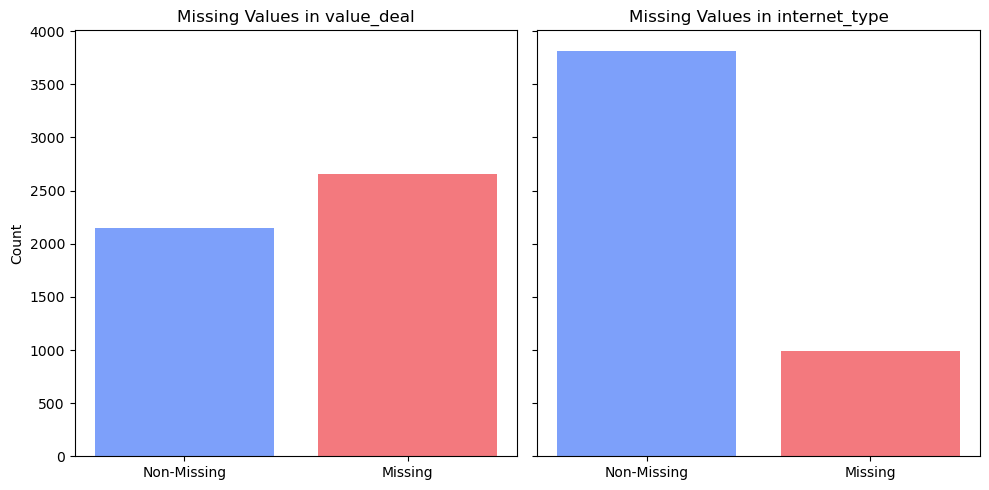

In [43]:
# Calculate missing values
missing_value_deal = train_df['value_deal'].isnull().sum()
missing_internet_type = train_df['internet_type'].isnull().sum()

# Calculate total rows for reference
total_rows = train_df.shape[0]

# Data for plotting
data = {
    'value_deal': [total_rows - missing_value_deal, missing_value_deal],
    'internet_type': [total_rows - missing_internet_type, missing_internet_type]
}

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharey=True)

# Plot for value_deal
axes[0].bar(['Non-Missing', 'Missing'], data['value_deal'], color=['#7DA0FA', '#F3797E'])
axes[0].set_title('Missing Values in value_deal')
axes[0].set_ylabel('Count')

# Plot for internet_type
axes[1].bar(['Non-Missing', 'Missing'], data['internet_type'], color=['#7DA0FA', '#F3797E'])
axes[1].set_title('Missing Values in internet_type')

# Show the plots
plt.tight_layout()
plt.show()

Handling Missing Values in value_deal and internet_type Columns

For the value_deal column, over 50% of the data is missing, making mode imputation potentially biased. Instead, we recommend using a new category like "Unknown" to avoid skewing the data. For the internet_type column, where fewer values are missing, imputing with the most frequent category is appropriate. This method ensures a balanced approach to handling missing data, maintaining the dataset's accuracy and integrity.

### 1.2 `describe()` method
Examine the output of `train_df.describe()` with `include='all'` argument and store it in a variable called `churn_summary`.

In [44]:
churn_summary = train_df.describe(include="all")
churn_summary

customer_id  gender          age married          state  \
count         4805    4805  4805.000000    4805           4805   
unique        4805       2          NaN       2             22   
top      81654-KER  Female          NaN     Yes  Uttar Pradesh   
freq             1    3023          NaN    2412            469   
mean           NaN     NaN    47.385224     NaN            NaN   
std            NaN     NaN    16.838818     NaN            NaN   
min            NaN     NaN    18.000000     NaN            NaN   
25%            NaN     NaN    33.000000     NaN            NaN   
50%            NaN     NaN    47.000000     NaN            NaN   
75%            NaN     NaN    60.000000     NaN            NaN   
max            NaN     NaN    84.000000     NaN            NaN   

        number_of_referrals  tenure_in_months value_deal phone_service  \
count           4805.000000       4805.000000       2145          4805   
unique                  NaN               NaN          5             2   
top                     NaN               NaN     Deal 2           Yes   
freq                    NaN               NaN        608          4333   
mean               7.408533         17.369199        NaN           NaN   
std                4.630768         10.587873        NaN           NaN   
min                0.000000          1.000000        NaN           NaN   
25%                3.000000          8.000000        NaN           NaN   
50%                7.000000         17.000000        NaN           NaN   
75%               11.000000         27.000000        NaN           NaN   
max               15.000000         36.000000        NaN           NaN   

       multiple_lines  ...   payment_method monthly_charge total_charges  \
count            4805  ...             4805    4805.000000   4805.000000   
unique              2  ...                3            NaN           NaN   
top                No  ...  Bank Withdrawal            NaN           NaN   
freq             2660  ...             2727            NaN           NaN   
mean              NaN  ...              NaN      65.006275   2428.003630   
std               NaN  ...              NaN      31.265832   2264.392917   
min               NaN  ...              NaN     -10.000000     19.100000   
25%               NaN  ...              NaN      35.450000    541.900000   
50%               NaN  ...              NaN      71.100000   1556.850000   
75%               NaN  ...              NaN      90.600000   4003.000000   
max               NaN  ...              NaN     118.750000   8684.800000   

       total_refunds total_extra_data_charges total_long_distance_charges  \
count    4805.000000              4805.000000                 4805.000000   
unique           NaN                      NaN                         NaN   
top              NaN                      NaN                         NaN   
freq             NaN                      NaN                         NaN   
mean        2.092212                 6.992716                  797.131305   
std         8.185769                25.518947                  851.066220   
min         0.000000                 0.000000                    0.000000   
25%         0.000000                 0.000000                  110.800000   
50%         0.000000                 0.000000                  473.500000   
75%         0.000000                 0.000000                 1259.520000   
max        49.760000               150.000000                 3564.000000   

       total_revenue customer_status churn_category churn_reason  
count    4805.000000            4805           4805         4805  
unique           NaN               2              6           21  
top              NaN          Stayed         Others       Others  
freq             NaN            3429           3429         3429  
mean     3230.035438             NaN            NaN          NaN  
std      2845.021114             NaN            NaN          NaN  
min        21.6100

### 1.3 Visualizing features
1. Show the Frequency of Different Values in Numerical Columns in `train_df`.
2. Show the histograms of numerical columns, grouped by payment_method.

In [45]:
numeric_cols = train_df.select_dtypes('number').columns.tolist()
numeric_cols

['age',
 'number_of_referrals',
 'tenure_in_months',
 'monthly_charge',
 'total_charges',
 'total_refunds',
 'total_extra_data_charges',
 'total_long_distance_charges',
 'total_revenue']

In [46]:
# 1. Show the Frequency of Different Values in Numerical Columns in `train_df`.
alt.Chart(train_df).mark_bar().encode(
     alt.X(alt.repeat()).type('quantitative').bin(maxbins=40),
     y='count()',
).properties(
    width=300,
    height=200
).repeat(
    numeric_cols
)

alt.RepeatChart(...)

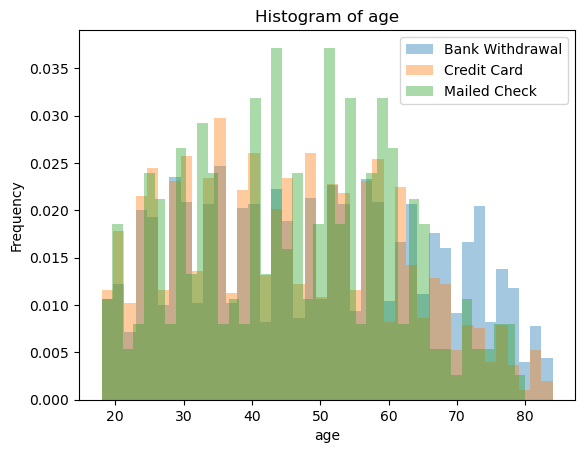

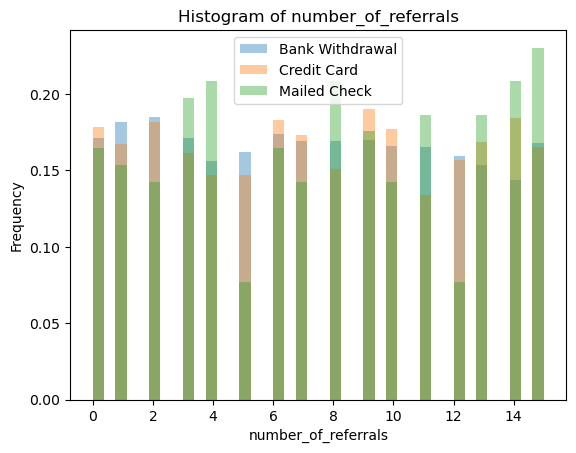

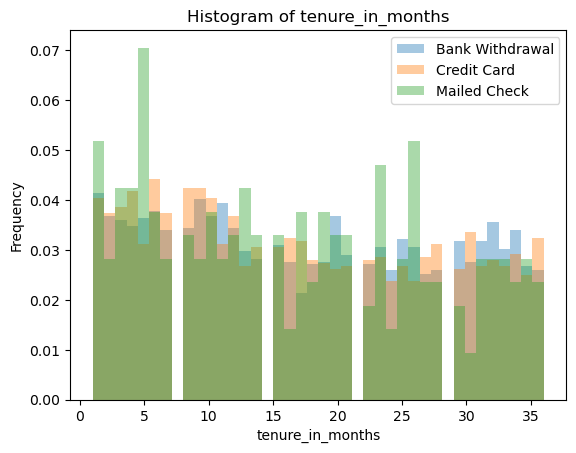

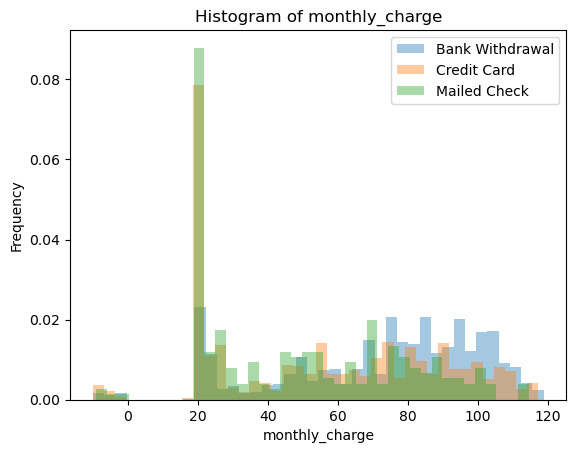

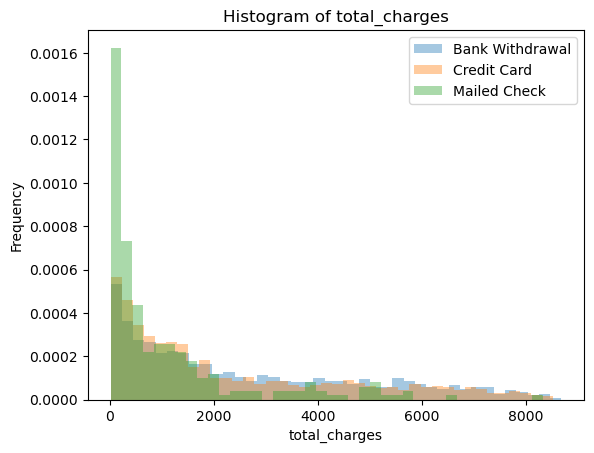

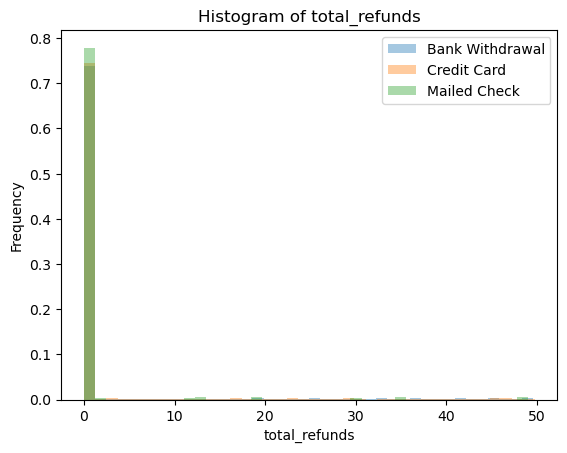

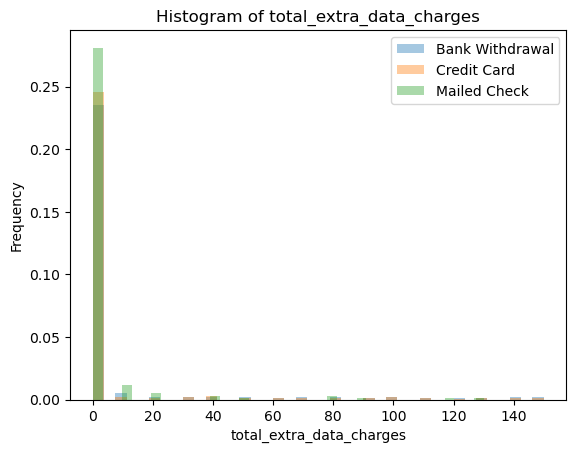

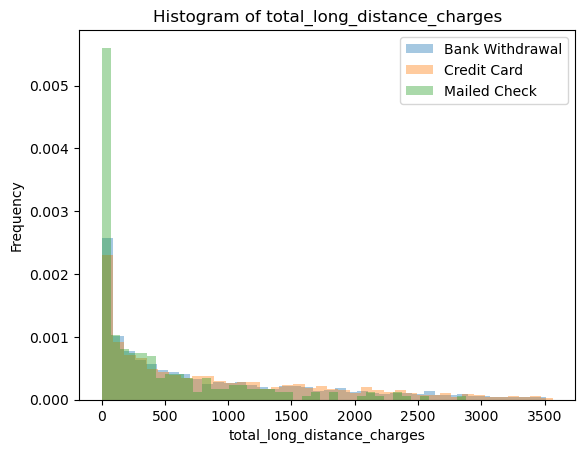

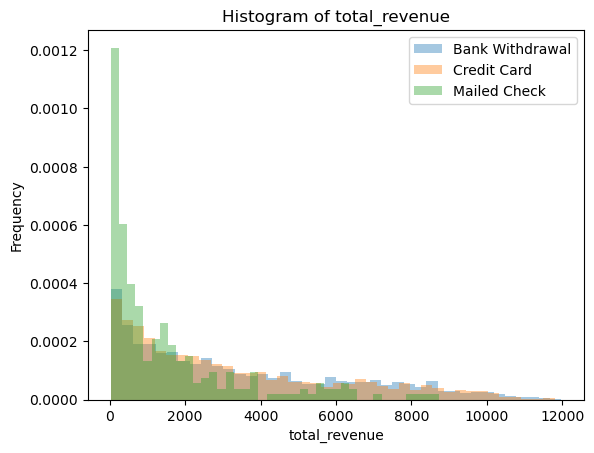

In [47]:
# 2. Show the histograms of numerical columns, grouped by payment_method.
for feat in numeric_cols:
    ax = train_df.groupby("payment_method")[feat].plot.hist(bins=40, alpha=0.4, legend=True, density=True)
    plt.xlabel(feat)
    plt.title("Histogram of " + feat)
    plt.show()

## Exercise 2: Identifying different feature types and transformations  
<hr>

Typically, data isn't readily formatted for direct input into machine learning models. It's crucial for a machine learning practitioner to examine each column and determine an effective method for encoding its information. Let's determine the types of features we have and come up with suitable encoding strategies for them. 

### 2.1 Identify transformations to apply
Before passing this data to a machine learning model, we need to apply some transformations on different features. Below we are providing possible transformations which can be applied on each column in `churn_df`.  

**our tasks:**
1. Write our justification or explanation for each row in the explanation column. 

> Note: This solution is a bit open-ended. If you do not agree with the provided transformation, feel free to argue your case in the explanation.

| Feature | Transformation | Explanation |
| --- | ----------- | ----- |
| customer_id | drop | Unique identifier for each customer, not relevant for modeling. |
| gender | one-hot encoding | Categorical feature with two categories: 'Male' and 'Female'. One-hot encoding is applied to convert it into numerical format. |
| age | scaling | Numeric feature with no missing values. Scaling is needed to normalize the range of this feature. |
| married | one-hot encoding | Categorical feature with two categories: 'Yes' and 'No'. One-hot encoding is used. |
| state | one-hot encoding | Categorical feature with multiple categories representing different states. One-hot encoding is applied. |
| number_of_referrals | scaling | Numeric feature with no missing values. Scaling is needed. |
| tenure_in_months | scaling | Numeric feature indicating the duration of customer tenure. Scaling is necessary. |
| value_deal | one-hot encoding | `Missing values variable`. Categorical feature representing different value deals. One-hot encoding is applied. |
| phone_service | one-hot encoding | Categorical feature indicating whether the customer has a phone service. One-hot encoding is applied. |
| multiple_lines | one-hot encoding | Categorical feature indicating whether the customer has multiple lines. One-hot encoding is applied. |
| internet_service | one-hot encoding | Categorical feature indicating the type of internet service. One-hot encoding is applied. |
| internet_type | one-hot encoding | `Missing values variable`. Categorical feature representing different types of internet services. One-hot encoding is applied. |
| online_security | one-hot encoding | Categorical feature indicating whether the customer has online security. One-hot encoding is applied. |
| online_backup | one-hot encoding | Categorical feature indicating whether the customer has online backup. One-hot encoding is applied. |
| device_protection_plan | one-hot encoding | Categorical feature indicating whether the customer has a device protection plan. One-hot encoding is applied. |
| premium_support | one-hot encoding | Categorical feature indicating whether the customer has premium support. One-hot encoding is applied. |
| streaming_tv | one-hot encoding | Categorical feature indicating whether the customer has a streaming TV service. One-hot encoding is applied. |
| streaming_movies | one-hot encoding | Categorical feature indicating whether the customer has a streaming movies service. One-hot encoding is applied. |
| streaming_music | one-hot encoding | Categorical feature indicating whether the customer has a streaming music service. One-hot encoding is applied. |
| unlimited_data | one-hot encoding | Categorical feature indicating whether the customer has unlimited data. One-hot encoding is applied. |
| contract | one-hot encoding | Categorical feature indicating the type of contract. One-hot encoding is applied. |
| paperless_billing | one-hot encoding | Categorical feature indicating whether the customer uses paperless billing. One-hot encoding is applied. |
| payment_method | one-hot encoding | Categorical feature indicating the payment method. One-hot encoding is applied. |
| monthly_charge | scaling | Numeric feature indicating the monthly charge. Scaling is necessary. |
| total_charges | scaling | Numeric feature indicating the total charges. Scaling is necessary. |
| total_refunds | scaling | Numeric feature indicating the total refunds. Scaling is necessary. |
| total_extra_data_charges | scaling | Numeric feature indicating extra data charges. Scaling is necessary. |
| total_long_distance_charges | scaling | Numeric feature indicating long-distance charges. Scaling is necessary. |
| total_revenue | scaling | Numeric feature indicating the total revenue generated from the customer. Scaling is necessary. |
| churn_category | drop | Categorical feature indicating the category of churn. This might be too specific or detailed for modeling (as it is highly related to our target variable) and can be excluded. |
| churn_reason | drop | Categorical feature providing the reason for churn. This might be too specific or detailed for modeling (as it is highly related to our target variable) and can be excluded. |
| `customer_status` | `Stayed`: 0, `Churned`: 1 | `Target variable` indicating whether the customer has stayed or churned.|


In [52]:
# Identify the unique values of the target variable
churn_df['customer_status'].unique()

array(['Stayed', 'Churned'], dtype=object)

In [55]:
# Drop columns that won't be used for prediction
churn_df = churn_df.drop(['customer_id', 'churn_category', 'churn_reason'], axis=1)

In [54]:
# Manually encode the target variable customer_status to prevent one-hot encoding from assuming `Churned` as 0 and `Stayed`` as 1.
churn_df['customer_status'] = churn_df['customer_status'].map({'Stayed': 0, 'Churn': 1})

## Exercise 3: Baseline models 

### 3.1 Separating feature vectors and targets  
Create `X_train`, `y_train`, `X_test`, `y_test` from `train_df` and `test_df`. 

In [56]:
target = 'customer_status'
X_train = train_df.drop(columns=[target])
y_train = train_df[target]

X_test = test_df.drop(columns=[target])
y_test = test_df[target]

### 3.2 Dummy classifier
 Carry out 5-fold cross-validation using [`scikit-learn`'s `cross_validate`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html) function with `return_train_score=True` and store the results as a dataframe named `dummy_df` where each row corresponds to the results from a cross-validation fold. 

In [57]:
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_validate

dummy = DummyClassifier()
scores = cross_validate(dummy, X_train, y_train, return_train_score=True)
dummy_df = pd.DataFrame(scores)
dummy_df

fit_time  score_time  test_score  train_score
0  0.002183    0.001263    0.713840      0.71358
1  0.002000    0.001228    0.713840      0.71358
2  0.001848    0.001008    0.713840      0.71358
3  0.001490    0.000930    0.713840      0.71358
4  0.001498    0.000944    0.712799      0.71384

If we were to train the [`sklearn`'s `SVC`](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) model on `X_train` and `y_train`, it won't work at this point because our data is not preprocessed yet; we have some categorical columns and some NaN values in two columns. We need to preprocess it first before feeding it into ML algorithms.

## Exercise 4: Column transformer 
<hr>

In this dataset, we have different types of features: numeric features, an ordinal feature, categorical features, and binary features. We want to apply different transformations on different columns and therefore we need a column transformer. First, we'll define different transformations on different types of features and then will create a `scikit-learn`'s `ColumnTransformer` using `make_column_transformer`. 